In [1]:
import numpy as np
import pandas as pd
import pickle
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

In [2]:
df0 = pd.read_parquet('pass0.parquet')
df1 = pd.read_parquet('pass1.parquet')

def get_timestamps(row):
    # algin obd.spd_veh and acc
    # row = df0.iloc[k]
    mask = row['GM.T'] == 'acc.xyz'
    accT = row['GM.TS_or_Distance'][mask]
    obdT = row['GM.TS_or_Distance'][~mask]
    return accT, obdT

In [3]:
# print(list(df0))
df0.head()

,IRI_mean,IRI_sequence,GM.TS_or_Distance,GM.T,GM.lat_int,GM.lon_int,GM.acc.xyz.z,GM.acc.xyz.y,GM.acc.xyz.x,GM.obd.spd_veh.value
0,4.933540,"[6.644882798499999, 5.5573473115, 7.666319952,...","[2021-04-22T01:21:54.349000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, obd.spd_v...","[55.654713308383236, 55.65471373053892, 55.654...","[12.486686901197604, 12.486686532934131, 12.48...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9922, 0.992...","[-0.1172, -0.1172, -0.1172, -0.1172, -0.1211, ...","[0.1602, 0.1602, 0.1602, 0.1602, 0.1563, 0.156...","[31.04, 31.0, 30.970000000000002, 31.470000000..."
1,4.696225,"[5.5573473115, 7.666319952, 4.1605364705, 5.35...","[2021-04-22T01:21:55.068000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654781462897525, 55.65478160070671, 55.654...","[12.48662899293286, 12.486628876325089, 12.486...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9727, 0.972...","[-0.0898, -0.0898, -0.0898, -0.0898, -0.0898, ...","[0.1406, 0.1406, 0.1406, 0.1406, 0.1406, 0.140...","[29.52, 29.48, 29.42, 29.400000000000002, 29.3..."
2,4.699145,"[7.666319952, 4.1605364705, 5.359907053000001,...","[2021-04-22T01:21:56.327000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654862308917195, 55.65486260509554, 55.654...","[12.486560579617835, 12.486560331210192, 12.48...","[1.0391, 1.0391, 1.0391, 1.0391, 1.0391, 1.015...","[0.0273, 0.0273, 0.0273, 0.0273, 0.0273, 0.011...","[0.1523, 0.1523, 0.1523, 0.1523, 0.1523, 0.160...","[30.080000000000002, 30.14, 30.2, 30.23, 29.54..."
3,4.397566,"[4.1605364705, 5.359907053000001, 4.5512844555...","[2021-04-22T01:21:57.983000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654942544169614, 55.65494265017668, 55.654...","[12.486492964664311, 12.486492879858657, 12.48...","[1.0391, 1.0391, 0.9805, 0.9805, 0.9805, 0.980...","[0.1016, 0.1016, 0.0898, 0.0898, 0.0898, 0.089...","[0.2188, 0.2188, 0.1953, 0.1953, 0.1953, 0.195...","[36.910000000000004, 37.0, 37.07, 37.18, 37.25..."
4,4.400549,"[5.359907053000001, 4.5512844555, 5.8527534034...","[2021-04-22T01:21:59.120000000, 2021-04-22T01:...","[obd.spd_veh, acc.xyz, acc.xyz, acc.xyz, acc.x...","[55.65502238338658, 55.65502269329073, 55.6550...","[12.486424923322684, 12.486424661341852, 12.48...","[0.9492, 0.9961, 0.9961, 0.9961, 0.9961, 0.996...","[0.0859, 0.0977, 0.0977, 0.0977, 0.0977, 0.097...","[0.1875, 0.1563, 0.1563, 0.1563, 0.1563, 0.156...","[41.2, 41.27, 41.38, 41.46, 41.53, 40.76, 41.6..."


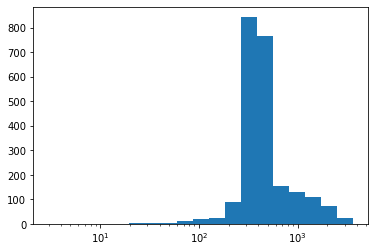

In [4]:
def plot_loghist(x, bins):
    logbins = np.logspace(np.log10(min(x)),np.log10(max(x)),bins)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.show()

# most recordings last ~2000 steps
zacc = df0['GM.obd.spd_veh.value']
plot_loghist(zacc.map(len), bins=20)
ZACC_df1 = df0['GM.obd.spd_veh.value']

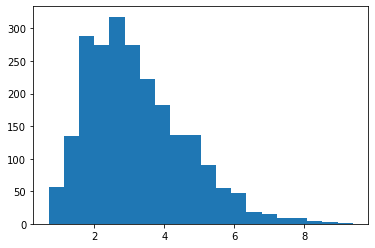

In [5]:
# distribution of IRI mean
iri = df0['IRI_mean']
plt.hist(iri, bins=20);

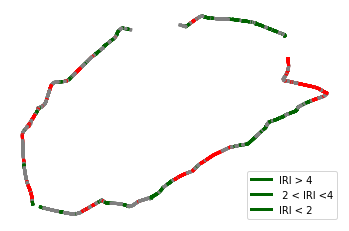

In [7]:
# snouglou
for _, row in df0.iterrows():
    riri = row['IRI_mean']
    c = 'darkgreen' if riri > 4 else 'red' if riri < 2 else 'grey' 
    plt.plot(row['GM.lat_int'], row['GM.lon_int'], c=c, linewidth=3)
    plt.legend(['IRI > 4', ' 2 < IRI <4','IRI < 2'])
    plt.axis('off')
plt.savefig('map.jpg')

<AxesSubplot:xlabel='GM.obd.spd_veh.value', ylabel='IRI_mean'>

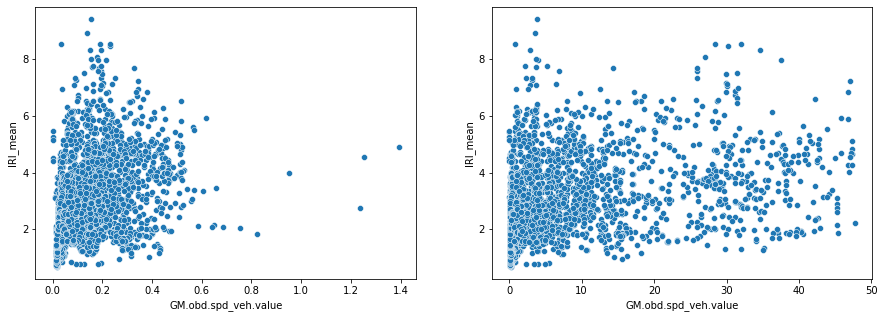

In [39]:
def mean_delta(seq):
    return np.abs(seq[1:] - seq[:-1]).mean()

def quantile_diff(seq, q=.15):
    return np.quantile(seq, 1-q) - np.quantile(seq, q)

a,b = zacc.map(mean_delta), zacc.map(quantile_diff)

dfplot = pd.DataFrame({'x':iri, 'y':a})
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(ax=ax[0],x=a,y=iri)
sns.scatterplot(ax=ax[1],x=b,y=iri)

#sns.scatterplot(ax=ax[0],data=arrays)

#ax[0].scatter(iri, a, s=.5)
#ax[1].scatter(iri, b, s=.5);

In [9]:
# np.corrcoef(iri, a)
np.corrcoef(iri, b)
# IRI is correlated with the displacement

array([[1.        , 0.27234231],
       [0.27234231, 1.        ]])

In [10]:
speed = df0['GM.obd.spd_veh.value']
min(speed.map(min)), max(speed.map(max))

(0.0, 63.24)

In [11]:
dts = df0['GM.TS_or_Distance'].map(np.diff)
# dts = dts[dts.map(len) > 2048].map(lambda x: x[:2048]).reset_index(drop=True)
dts = np.concatenate(dts).astype('float') / 1e9
len(dts[dts > 1])

413

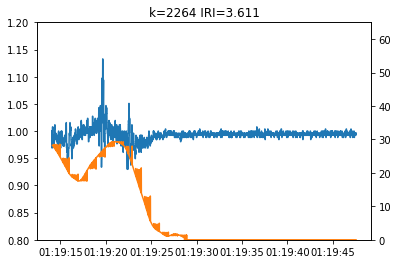

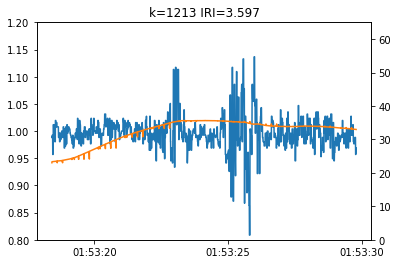

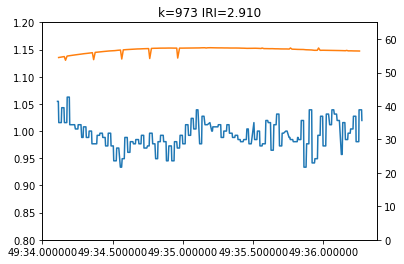

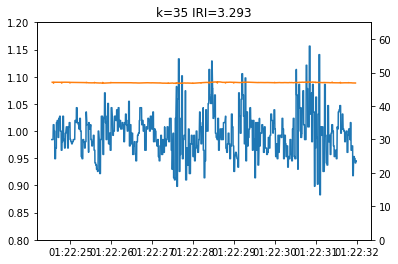

In [12]:
for _ in range(4):
    i = np.random.randint(0,n)
    s0 = df0.loc[i]
    accT, obdT = get_timestamps(s0)
    accZ = s0['GM.acc.xyz.z']
    obd = s0['GM.obd.spd_veh.value']
    # obd = gaussian_filter1d(obd, 3)
    
    # plt.plot(accZ)
    fig, ax1 = plt.subplots()
    ax1.set_title('k=%d IRI=%.3f' % (i,iri[i]))
    ax2 = ax1.twinx()
    ax1.plot(accT, accZ, color='#1f77b4')
    ax1.set_ylim(.8, 1.2)
    ax2.plot(obdT, obd, color='#ff7f0e')
    ax2.set_ylim(0, 65);

# we notice some clipping on the orange curve (?)

In [33]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TruncatedDS(Dataset):
    """
    In this dataset, all time series are truncated to the 0.1 quantile
    or size, if provided
    """
    def __init__(self, fname, size=None, align=32):
        df = pd.read_parquet(fname)
        zacc = df['GM.acc.xyz.z'] # Series[arr[:]float]
        print("zacc ", zacc.shape, size)
        print("zacc [0]", zacc[0].shape, size)
        print("zacc [1]", zacc[0].shape, size)
        print("zacc [2]", zacc[0].shape, size)


        iri = df['IRI_mean'] # Series[float]
        
        if not size:
            size = zacc.map(len).quantile(.1)
            size = (int(size) // align) * align
        self.sz = size
        mask = zacc.map(len) >= size
        zacc = zacc[mask] 
        iri = iri[mask]
        
        def truncate(arr):
            return arr[:size]
        zacc = np.stack(zacc.map(truncate)).astype('float32')
        print("zacc ",zacc.shape, size)
        self.zacc = zacc
        self.iri = iri.values.astype('float32')
        
        print('TruncatedDS initialized with size = %d, len = %d' % (size,len(zacc)))
        
        #transposed_data = list(zip(*data))
        #self.inp = torch.stack(transposed_data[0], 0)
        #self.tgt = torch.stack(transposed_data[1], 0)
    def __getitem__(self, idx):
        return self.zacc[idx][None,:], self.iri[idx]
    
    def __len__(self):
        return len(self.zacc)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# https://keras.io/examples/timeseries/timeseries_anomaly_detection/
class AE1(nn.Module):
    def __init__(self, din=1, depth=2, w=7, h1=16, h2=1):
        super().__init__()
        assert depth >= 2
        pad = {'padding':'same', 'padding_mode':'reflect'}
        
        enc = [
            nn.Conv1d(din, h1, w, **pad),
            nn.MaxPool1d(2,2),
            nn.ReLU(),
            nn.Dropout(.2),
        ]
        dec = [
            nn.Conv1d(h1, h1, w, **pad),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(h1, din, w, **pad),
        ]
        for _ in range(2, depth):
            enc += [
                nn.Conv1d(h1, h1, w, **pad),
                nn.MaxPool1d(2,2),
                nn.ReLU(),
                nn.Dropout(.2),
            ]
            dec = [            
                nn.Conv1d(h1, h1, w, **pad),
                nn.ReLU(),
                nn.Upsample(scale_factor=2),
                nn.Dropout(.2),
            ] + dec
        enc += [
            nn.Conv1d(h1, h2, w, **pad),
            nn.MaxPool1d(2,2),
            nn.ReLU(),
        ]
        dec = [
            nn.Conv1d(h2, h1, w, **pad),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(.2),
        ] + dec
        
        self.encoder = nn.Sequential(*enc)
        self.decoder = nn.Sequential(*dec)
        
    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
def get_trivial_mse(dataset, scale=8):
    def get_one(x):
        x,_ = x
        x1 = F.avg_pool1d(x,scale,scale)
        x1 = F.interpolate(x1, scale_factor=scale)
        return F.mse_loss(x1,x)

    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    return float(np.array(list(map(get_one, dataloader))).mean())

In [34]:
def train(model, dataset, epochs, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    hist = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for x,_ in dataloader:
            pred = model(x)
            loss = loss_fn(pred, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += float(loss) * x.size(0)

        hist.append(running_loss / len(dataset))
    return hist

In [17]:
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
# model = AE1()
# model(next(iter(dataloader)))


In [41]:
L = 2048
dataset = TruncatedDS('pass0.parquet', L)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

zacc  (2274,) 2048
zacc [0] (2539,) 2048
zacc [1] (2539,) 2048
zacc [2] (2539,) 2048
zacc  (1460, 2048) 2048
TruncatedDS initialized with size = 2048, len = 1460


In [42]:
models = []
def train_model(epochs=40, batch_size=4, **kwargs):
    model = AE1(**kwargs)
    hist = train(model, dataset, epochs, batch_size)
    models.append((model, hist, kwargs))

In [66]:
# train_model(depth=4, h2=4)
train_model(epochs=70, depth=2, h2=8)

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [04:16<00:00,  3.66s/it]


In [71]:
scale = 2
print('compression x%d, trivial MSE: %f' % (scale, get_trivial_mse(dataset, scale)))
scale = 4
print('compression x%d, trivial MSE: %f' % (scale, get_trivial_mse(dataset, scale)))
scale = 8
print('compression x%d, trivial MSE: %f' % (scale, get_trivial_mse(dataset, scale)))
scale = 16
print('compression x%d, trivial MSE: %f' % (scale, get_trivial_mse(dataset, scale)))
scale = 32
print('compression x%d, trivial MSE: %f' % (scale, get_trivial_mse(dataset, scale)))

compression x2, trivial MSE: 0.000074
compression x4, trivial MSE: 0.000183
compression x8, trivial MSE: 0.000370
compression x16, trivial MSE: 0.000610
compression x32, trivial MSE: 0.000787


In [72]:
def show_report(model):
    model, hist, _ = models[model]
    fig, ax = plt.subplots(1,1, figsize=(11,5))
    
    #sns.lineplot(ax=ax[0],data=hist)
    ax.plot(hist, linewidth=4)
    ax.set_yscale('log')

interact(show_report, model=[((i,models[i][2]), i) for i in range(len(models))]);

interactive(children=(Dropdown(description='model', options=(((0, {'depth': 2, 'h2': 4}), 0), ((1, {'depth': 2…

In [75]:
#len(models[0])
models[2]

(AE1(
   (encoder): Sequential(
     (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
     (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): ReLU()
     (3): Dropout(p=0.2, inplace=False)
     (4): Conv1d(16, 8, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
     (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): ReLU()
   )
   (decoder): Sequential(
     (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode=nearest)
     (3): Dropout(p=0.2, inplace=False)
     (4): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
     (5): ReLU()
     (6): Upsample(scale_factor=2.0, mode=nearest)
     (7): Conv1d(16, 1, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
   )
 ),
 [0.03272064484987561,
  0.004282959093250436,
  0.0

In [76]:
def show_report(model):
    model, hist, _ = models[model]
    fig, ax = plt.subplots(2,2, figsize=(14,10))

    with torch.no_grad():
        x,iri = next(iter(dataloader))
        #ax[1].plot(x[0,0].numpy())
        sns.lineplot(ax=ax[0,0],data=x[1,0].numpy(),label='true')
        sns.lineplot(ax=ax[0,0],data=model(x)[1,0].numpy(),label='reconstructed')
        ax[0,0].set_ylim(.8, 1.2)
        ax[0,0].set_xlabel('Time', fontsize=10)
        ax[0,0].set_ylabel('Acc Z', fontsize=10)
        ax[0,0].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        sns.lineplot(ax=ax[1,0],data=x[2,0].numpy(),label='true')
        sns.lineplot(ax=ax[1,0],data=model(x)[2,0].numpy(),label='reconstructed')
        ax[1,0].set_ylim(.8, 1.2)
        ax[1,0].set_xlabel('Time', fontsize=10)
        ax[1,0].set_ylabel('Acc Z', fontsize=10)
        sns.lineplot(ax=ax[1,1],data=x[3,0].numpy(),label='true')
        sns.lineplot(ax=ax[1,1],data=model(x)[3,0].numpy(),label='reconstructed')
        ax[1,1].set_ylim(.8, 1.2)
        ax[1,1].set_xlabel('Time', fontsize=10)
        ax[1,1].set_ylabel('Acc Z', fontsize=10)
        sns.lineplot(ax=ax[0,1],data=x[0,0].numpy(),label='true')
        sns.lineplot(ax=ax[0,1],data=model(x)[0,0].numpy(),label='reconstructed')
        ax[0,1].set_ylim(.8, 1.2)
        ax[0,1].set_xlabel('Time', fontsize=10)
        ax[0,1].set_ylabel('Acc Z', fontsize=10)


interact(show_report, model=[((i,models[i][2]), i) for i in range(len(models))]);

interactive(children=(Dropdown(description='model', options=(((0, {'depth': 2, 'h2': 4}), 0), ((1, {'depth': 2…

In [63]:
model

AE1(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(16, 4, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): Conv1d(4, 16, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
    (5): ReLU()
    (6): Upsample(scale_factor=2.0, mode=nearest)
    (7): Conv1d(16, 1, kernel_size=(7,), stride=(1,), padding=same, padding_mode=reflect)
  )
)

In [79]:
## visualization
model = models[0][1]

for _ in range(3):
    i = np.random.randint(0,n)
    x = torch.tensor(zacc[i].astype('float32')).view(1,1,-1)
    with torch.no_grad():
        x = model.encoder(x).numpy()
    print("k=%d IRI=%.5f" % (i, iri[i]))
    plt.scatter(*x[0,2:], s=5);

AttributeError: 'list' object has no attribute 'encoder'

In [55]:
## prediction

batch_size = 4
epochs = 15

rnn = nn.LSTM(input_size=4, hidden_size=32, num_layers=1, proj_size=1, batch_first=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

hist1 = []
for epoch in (range(epochs)):
    running_loss = 0
    for x,iri in tqdm(dataloader):
        with torch.no_grad():
            z = model.encoder(x)
        y,_ = rnn(torch.transpose(z,1,2))
        loss = loss_fn(y[:,-1,0], iri)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss)

        running_loss += float(loss) * x.size(0)

    hist1.append(running_loss / len(dataset))


100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [00:42<00:00,  8.56it/s]


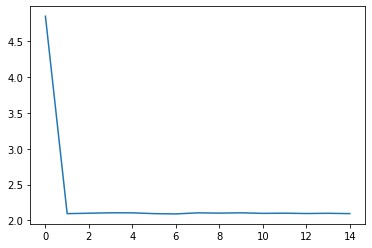

In [56]:
plt.plot(hist1)
hist_linreg_on_whole_input = hist1

In [57]:
## prediction

batch_size = 4
epochs = 15

rnn = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, proj_size=1, batch_first=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

hist2 = []
for epoch in (range(epochs)):
    running_loss = 0
    for x,iri in tqdm(dataloader):
        y,_ = rnn(torch.transpose(x,1,2))
        loss = loss_fn(y[:,-1,0], iri)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss)

        running_loss += float(loss) * x.size(0)

    hist2.append(running_loss / len(dataset))


100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [02:08<00:00,  2.84it/s]


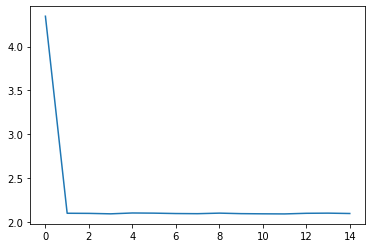

In [58]:
plt.plot(hist2)
hist_lstm_on_whole_input = hist2

In [59]:
linreg = nn.Linear(1,1)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(linreg.parameters(), lr=1e-3)

hist3 = []
for epoch in tqdm(range(15)):
    running_loss = 0
    for x,iri in (dataloader):
        z = np.mean(np.abs(np.diff(np.array(x))), axis=-1)[:,None]
        z = torch.tensor(z)
        y = linreg(z)
        loss = loss_fn(y[:,-1,0], iri)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss)

        running_loss += float(loss) * x.size(0)

    hist3.append(running_loss / len(dataset))


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.33it/s]


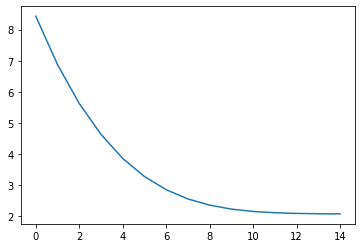

In [62]:
plt.plot(hist3);

In [ ]:
list(linreg.parameters())

In [ ]:
plt.plot(hist_linreg_on_whole_input, label='LinReg',linewidth=2)
plt.plot(hist2,'--', label='LSTM',linewidth=2)
plt.plot(hist3, label='LSTM on latent space',linewidth=2)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend()
plt.show()

In [82]:
hist3

[8.427484764791515,
 6.874627031937037,
 5.6248652697426,
 4.634276077886151,
 3.862299258374188,
 3.281783344627243,
 2.8592054449736257,
 2.5626923755117477,
 2.363865941150548,
 2.2368038053892247,
 2.161294594243781,
 2.119821371219746,
 2.098442214809052,
 2.087721742301771,
 2.0825419601512283]